In [1]:
%pip install gdown
%pip install tqdm
import gdown

url = "https://drive.google.com/drive/folders/1iYO-Kwh4RFq6mm5UNPTRO7te8T6jOA6f?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/Dataset/AlexNet.py',
 '/content/Dataset/custom_cnn.py',
 '/content/Dataset/Dataset_resized.zip']

In [2]:
import os
import zipfile
import shutil
from tqdm import tqdm
from collections import defaultdict
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
from Dataset.AlexNet import AlexNet
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from torch.utils.data import Subset
import seaborn as sns
import matplotlib.pyplot as plt
import math


# path of the dataset
dataset_path = "Dataset"

# extract zip files and remove them
def extract_and_remove_zip(zip_path, extract_to):
    """
    Estrae il contenuto di un file zip e poi elimina il file zip.
    Args:
        zip_path (str): percorso del file zip da estrarre.
        extract_to (str): cartella di destinazione in cui estrarre i file.
    """
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    os.remove(zip_path)
    print(f"File zip {zip_path} estratto e rimosso.")

zip_files = [f for f in os.listdir(dataset_path) if f.endswith('.zip')]
for zip_file in zip_files:
    zip_path = os.path.join(dataset_path, zip_file)
    extract_and_remove_zip(zip_path, dataset_path)


print("Process completed!")




File zip Dataset/Dataset_resized.zip estratto e rimosso.
Process completed!


**Conteggio numero immagini per ogni set**

In [3]:
dataset_path = "Dataset"
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)

    if os.path.isdir(folder_path):
        train_folder = os.path.join(folder_path, "train")
        test_folder = os.path.join(folder_path, "test")

        train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
        test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

        print(f"Cartella '{folder}':")
        print(f"  Train set: {train_count} file")
        print(f"  Test set: {test_count} file")

Cartella 'nose':
  Train set: 18255 file
  Test set: 4776 file
Cartella 'mouth':
  Train set: 18255 file
  Test set: 4776 file
Cartella '__pycache__':
  Train set: 0 file
  Test set: 0 file
Cartella 'eyes':
  Train set: 18255 file
  Test set: 4776 file


In [3]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
# Transform eyes (266 x 44)
transform_eyes = transforms.Compose([
    transforms.Resize((44, 266)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.56551169, 0.4201522,  0.35519068], std = [0.22746577, 0.20109357, 0.19388984])
])

# Transform nose (108x170)
transform_nose = transforms.Compose([
    transforms.Resize((170, 108)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.70585869, 0.5230923,  0.44163547], std = [0.19556989, 0.19164655, 0.19488743])
])

# Transform mouth (193x89)
transform_mouth = transforms.Compose([
    transforms.Resize((89, 193)), 
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.64867712, 0.4592991,  0.39606173], std = [0.2005014,  0.18597975, 0.18335514])
])

class EthnicityDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                self.images.append(filename)

                # extract labels
                # example: eyes_100_1_0_20170112213001988
                parts = filename.split('_')
                if len(parts) >= 4:
                    label = parts[3]  # fourth element (index 3)
                    label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Map ethnicities
                    self.labels.append(label_map.get(label, -1))  # no ethnicity found

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Error: loading of the image {image_path}: {e}")
            return None, None

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        # Check if label is correct
        if label == -1:
            print(f"Error: no label found {image_name}")

        return image, label

In [5]:
def get_output_size(input_width, input_height):
    # Layer 1: Conv2d + MaxPool2d
    # Conv2d parameters: kernel_size=11, stride=4, padding=0
    # MaxPool2d parameters: kernel_size=2, stride=2
    x1 = math.floor((input_width - 11) / 4) + 1  # Conv2d (kernel 11, stride 4, padding 0)
    y1 = math.floor((input_height - 11) / 4) + 1  # Conv2d
    x1 = math.floor(x1 / 2)  # MaxPool2d (stride 2)
    y1 = math.floor(y1 / 2)  # MaxPool2d

    # Layer 2: Conv2d + MaxPool2d
    # Conv2d parameters: kernel_size=5, stride=1, padding=2
    # MaxPool2d parameters: kernel_size=2, stride=2
    x2 = math.floor((x1 - 5 + 2 * 2) / 1) + 1  # Conv2d (kernel 5, stride 1, padding 2)
    y2 = math.floor((y1 - 5 + 2 * 2) / 1) + 1  # Conv2d
    x2 = math.floor(x2 / 2)  # MaxPool2d
    y2 = math.floor(y2 / 2)  # MaxPool2d

    # Layer 3: Conv2d + MaxPool2d
    # Conv2d parameters: kernel_size=3, stride=1, padding=1
    # MaxPool2d parameters: kernel_size=2, stride=2
    x3 = math.floor((x2 - 3 + 2 * 1) / 1) + 1  # Conv2d (kernel 3, stride 1, padding 1)
    y3 = math.floor((y2 - 3 + 2 * 1) / 1) + 1  # Conv2d
    x3 = math.floor(x3 / 2)  # MaxPool2d
    y3 = math.floor(y3 / 2)  # MaxPool2d

    # Layer 4: Conv2d
    # Conv2d parameters: kernel_size=3, stride=1, padding=1
    x4 = math.floor((x3 - 3 + 2 * 1) / 1) + 1  # Conv2d (kernel 3, stride 1, padding 1)
    y4 = math.floor((y3 - 3 + 2 * 1) / 1) + 1  # Conv2d

    # Layer 5: Conv2d
    # Conv2d parameters: kernel_size=3, stride=1, padding=1
    x5 = math.floor((x4 - 3 + 2 * 1) / 1) + 1  # Conv2d (kernel 3, stride 1, padding 1)
    y5 = math.floor((y4 - 3 + 2 * 1) / 1) + 1  # Conv2d

    # Final output: return the final output dimensions
    return x5, y5

ex = 266
ey = 44
nx = 108
ny = 170
mx = 193
my = 89


ex, ey = get_output_size(ex, ey)
nx, ny = get_output_size(nx, ny)
mx, my = get_output_size(mx, my)


class_names = ["White", "Black", "Asian", "Indian", "Others"]

**EYES TRAINING VALIDATION AND TEST**

In [9]:
# Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/eyes/train", transform=transform_eyes)
test_dataset = EthnicityDataset(root_dir="Dataset/eyes/test", transform=transform_eyes)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-fold Cross-Validation
k = 5  # Choose K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array to store results for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

num_epochs = 12
batch_size = 64

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model and optimizer for each fold
    eyes_net = AlexNet(ex,ey)
    eyes_net = eyes_net.to(device)  # Ensure the model is on the correct GPU/CPU
    eyes_optimizer = torch.optim.Adam(eyes_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Metrics for each fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training for each fold
    for epoch in range(num_epochs):
        # Training Phase
        eyes_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            eyes_optimizer.zero_grad()

            # Forward pass
            outputs = eyes_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            eyes_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        eyes_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = eyes_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = eyes_net.state_dict()
            print(f"New best model saved with Val Accuracy: {best_val_accuracy:.4f}")
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save results for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

torch.save(best_model_state, "best_eyes_net.pth")

# Calculate the average metrics across all folds
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 229/229 [00:20<00:00, 11.30batch/s]


Fold 1, Epoch 1, Train Loss: 1.3044, Train Accuracy: 0.5134


Validating Fold 1, Epoch 1: 100%|██████████| 58/58 [00:07<00:00,  7.34batch/s]


New best model saved with Val Accuracy: 0.5251
Fold 1, Epoch 1, Val Loss: 1.2078, Val Accuracy: 0.5251


Training Fold 1, Epoch 2: 100%|██████████| 229/229 [00:23<00:00,  9.58batch/s]


Fold 1, Epoch 2, Train Loss: 1.1145, Train Accuracy: 0.5863


Validating Fold 1, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 18.13batch/s]


New best model saved with Val Accuracy: 0.5448
Fold 1, Epoch 2, Val Loss: 1.3058, Val Accuracy: 0.5448


Training Fold 1, Epoch 3: 100%|██████████| 229/229 [00:17<00:00, 12.86batch/s]


Fold 1, Epoch 3, Train Loss: 1.0257, Train Accuracy: 0.6269


Validating Fold 1, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.49batch/s]


New best model saved with Val Accuracy: 0.6283
Fold 1, Epoch 3, Val Loss: 1.0038, Val Accuracy: 0.6283


Training Fold 1, Epoch 4: 100%|██████████| 229/229 [00:17<00:00, 12.87batch/s]


Fold 1, Epoch 4, Train Loss: 0.9553, Train Accuracy: 0.6583


Validating Fold 1, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.47batch/s]


New best model saved with Val Accuracy: 0.6330
Fold 1, Epoch 4, Val Loss: 1.0063, Val Accuracy: 0.6330


Training Fold 1, Epoch 5: 100%|██████████| 229/229 [00:19<00:00, 11.92batch/s]


Fold 1, Epoch 5, Train Loss: 0.9191, Train Accuracy: 0.6704


Validating Fold 1, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 18.12batch/s]


New best model saved with Val Accuracy: 0.6516
Fold 1, Epoch 5, Val Loss: 0.9622, Val Accuracy: 0.6516


Training Fold 1, Epoch 6: 100%|██████████| 229/229 [00:17<00:00, 12.74batch/s]


Fold 1, Epoch 6, Train Loss: 0.8834, Train Accuracy: 0.6867


Validating Fold 1, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 15.43batch/s]


Fold 1, Epoch 6, Val Loss: 0.9546, Val Accuracy: 0.6508


Training Fold 1, Epoch 7: 100%|██████████| 229/229 [00:17<00:00, 12.78batch/s]


Fold 1, Epoch 7, Train Loss: 0.8427, Train Accuracy: 0.6995


Validating Fold 1, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 18.67batch/s]


New best model saved with Val Accuracy: 0.6656
Fold 1, Epoch 7, Val Loss: 0.9076, Val Accuracy: 0.6656


Training Fold 1, Epoch 8: 100%|██████████| 229/229 [00:18<00:00, 12.65batch/s]


Fold 1, Epoch 8, Train Loss: 0.8132, Train Accuracy: 0.7095


Validating Fold 1, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 16.67batch/s]


New best model saved with Val Accuracy: 0.6899
Fold 1, Epoch 8, Val Loss: 0.8524, Val Accuracy: 0.6899


Training Fold 1, Epoch 9: 100%|██████████| 229/229 [00:17<00:00, 12.82batch/s]


Fold 1, Epoch 9, Train Loss: 0.7799, Train Accuracy: 0.7219


Validating Fold 1, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 17.01batch/s]


New best model saved with Val Accuracy: 0.7012
Fold 1, Epoch 9, Val Loss: 0.8355, Val Accuracy: 0.7012


Training Fold 1, Epoch 10: 100%|██████████| 229/229 [00:18<00:00, 12.46batch/s]


Fold 1, Epoch 10, Train Loss: 0.7613, Train Accuracy: 0.7300


Validating Fold 1, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 18.57batch/s]


Fold 1, Epoch 10, Val Loss: 0.8313, Val Accuracy: 0.6971


Training Fold 1, Epoch 11: 100%|██████████| 229/229 [00:17<00:00, 12.86batch/s]


Fold 1, Epoch 11, Train Loss: 0.7215, Train Accuracy: 0.7445


Validating Fold 1, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 14.82batch/s]


Fold 1, Epoch 11, Val Loss: 0.8244, Val Accuracy: 0.6919


Training Fold 1, Epoch 12: 100%|██████████| 229/229 [00:17<00:00, 12.79batch/s]


Fold 1, Epoch 12, Train Loss: 0.6920, Train Accuracy: 0.7553


Validating Fold 1, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 18.05batch/s]


Fold 1, Epoch 12, Val Loss: 0.8775, Val Accuracy: 0.6861
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 229/229 [00:18<00:00, 12.46batch/s]


Fold 2, Epoch 1, Train Loss: 1.3331, Train Accuracy: 0.4925


Validating Fold 2, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 18.48batch/s]


Fold 2, Epoch 1, Val Loss: 1.1818, Val Accuracy: 0.5546


Training Fold 2, Epoch 2: 100%|██████████| 229/229 [00:17<00:00, 13.03batch/s]


Fold 2, Epoch 2, Train Loss: 1.1492, Train Accuracy: 0.5714


Validating Fold 2, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.08batch/s]


Fold 2, Epoch 2, Val Loss: 1.2792, Val Accuracy: 0.4829


Training Fold 2, Epoch 3: 100%|██████████| 229/229 [00:17<00:00, 12.96batch/s]


Fold 2, Epoch 3, Train Loss: 1.0616, Train Accuracy: 0.6078


Validating Fold 2, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 18.42batch/s]


Fold 2, Epoch 3, Val Loss: 1.0275, Val Accuracy: 0.6371


Training Fold 2, Epoch 4: 100%|██████████| 229/229 [00:17<00:00, 12.84batch/s]


Fold 2, Epoch 4, Train Loss: 0.9894, Train Accuracy: 0.6424


Validating Fold 2, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.38batch/s]


Fold 2, Epoch 4, Val Loss: 0.9336, Val Accuracy: 0.6576


Training Fold 2, Epoch 5: 100%|██████████| 229/229 [00:17<00:00, 13.02batch/s]


Fold 2, Epoch 5, Train Loss: 0.9485, Train Accuracy: 0.6605


Validating Fold 2, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 18.56batch/s]


Fold 2, Epoch 5, Val Loss: 1.0070, Val Accuracy: 0.6212


Training Fold 2, Epoch 6: 100%|██████████| 229/229 [00:18<00:00, 12.64batch/s]


Fold 2, Epoch 6, Train Loss: 0.9034, Train Accuracy: 0.6766


Validating Fold 2, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 18.42batch/s]


Fold 2, Epoch 6, Val Loss: 0.8633, Val Accuracy: 0.6875


Training Fold 2, Epoch 7: 100%|██████████| 229/229 [00:17<00:00, 13.16batch/s]


Fold 2, Epoch 7, Train Loss: 0.8683, Train Accuracy: 0.6908


Validating Fold 2, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 14.74batch/s]


Fold 2, Epoch 7, Val Loss: 0.9072, Val Accuracy: 0.6661


Training Fold 2, Epoch 8: 100%|██████████| 229/229 [00:17<00:00, 13.10batch/s]


Fold 2, Epoch 8, Train Loss: 0.8395, Train Accuracy: 0.7011


Validating Fold 2, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 18.59batch/s]


Fold 2, Epoch 8, Val Loss: 0.8650, Val Accuracy: 0.6858


Training Fold 2, Epoch 9: 100%|██████████| 229/229 [00:17<00:00, 12.73batch/s]


Fold 2, Epoch 9, Train Loss: 0.8123, Train Accuracy: 0.7119


Validating Fold 2, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 17.49batch/s]


Fold 2, Epoch 9, Val Loss: 0.8442, Val Accuracy: 0.6987


Training Fold 2, Epoch 10: 100%|██████████| 229/229 [00:17<00:00, 13.10batch/s]


Fold 2, Epoch 10, Train Loss: 0.7844, Train Accuracy: 0.7195


Validating Fold 2, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 18.15batch/s]


Fold 2, Epoch 10, Val Loss: 1.0621, Val Accuracy: 0.5993


Training Fold 2, Epoch 11: 100%|██████████| 229/229 [00:18<00:00, 12.50batch/s]


Fold 2, Epoch 11, Train Loss: 0.7481, Train Accuracy: 0.7362


Validating Fold 2, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 18.52batch/s]


Fold 2, Epoch 11, Val Loss: 0.8643, Val Accuracy: 0.6850


Training Fold 2, Epoch 12: 100%|██████████| 229/229 [00:17<00:00, 13.09batch/s]


Fold 2, Epoch 12, Train Loss: 0.7208, Train Accuracy: 0.7431


Validating Fold 2, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 14.74batch/s]


New best model saved with Val Accuracy: 0.7127
Fold 2, Epoch 12, Val Loss: 0.8105, Val Accuracy: 0.7127
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 229/229 [00:17<00:00, 13.05batch/s]


Fold 3, Epoch 1, Train Loss: 1.3012, Train Accuracy: 0.5068


Validating Fold 3, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 18.39batch/s]


Fold 3, Epoch 1, Val Loss: 1.2029, Val Accuracy: 0.5642


Training Fold 3, Epoch 2: 100%|██████████| 229/229 [00:18<00:00, 12.64batch/s]


Fold 3, Epoch 2, Train Loss: 1.0974, Train Accuracy: 0.5918


Validating Fold 3, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 17.06batch/s]


Fold 3, Epoch 2, Val Loss: 1.0240, Val Accuracy: 0.6220


Training Fold 3, Epoch 3: 100%|██████████| 229/229 [00:17<00:00, 13.01batch/s]


Fold 3, Epoch 3, Train Loss: 1.0243, Train Accuracy: 0.6292


Validating Fold 3, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 17.74batch/s]


Fold 3, Epoch 3, Val Loss: 0.9675, Val Accuracy: 0.6494


Training Fold 3, Epoch 4: 100%|██████████| 229/229 [00:18<00:00, 12.53batch/s]


Fold 3, Epoch 4, Train Loss: 0.9716, Train Accuracy: 0.6528


Validating Fold 3, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 18.60batch/s]


Fold 3, Epoch 4, Val Loss: 0.9543, Val Accuracy: 0.6527


Training Fold 3, Epoch 5: 100%|██████████| 229/229 [00:17<00:00, 13.11batch/s]


Fold 3, Epoch 5, Train Loss: 0.9304, Train Accuracy: 0.6680


Validating Fold 3, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 14.48batch/s]


Fold 3, Epoch 5, Val Loss: 0.9376, Val Accuracy: 0.6708


Training Fold 3, Epoch 6: 100%|██████████| 229/229 [00:17<00:00, 13.09batch/s]


Fold 3, Epoch 6, Train Loss: 0.8834, Train Accuracy: 0.6842


Validating Fold 3, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 18.55batch/s]


Fold 3, Epoch 6, Val Loss: 0.9299, Val Accuracy: 0.6639


Training Fold 3, Epoch 7: 100%|██████████| 229/229 [00:17<00:00, 12.74batch/s]


Fold 3, Epoch 7, Train Loss: 0.8528, Train Accuracy: 0.6964


Validating Fold 3, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 17.54batch/s]


Fold 3, Epoch 7, Val Loss: 0.8470, Val Accuracy: 0.6941


Training Fold 3, Epoch 8: 100%|██████████| 229/229 [00:17<00:00, 13.08batch/s]


Fold 3, Epoch 8, Train Loss: 0.8227, Train Accuracy: 0.7078


Validating Fold 3, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 17.79batch/s]


Fold 3, Epoch 8, Val Loss: 0.8836, Val Accuracy: 0.6872


Training Fold 3, Epoch 9: 100%|██████████| 229/229 [00:18<00:00, 12.50batch/s]


Fold 3, Epoch 9, Train Loss: 0.7931, Train Accuracy: 0.7186


Validating Fold 3, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 18.80batch/s]


Fold 3, Epoch 9, Val Loss: 0.9187, Val Accuracy: 0.6705


Training Fold 3, Epoch 10: 100%|██████████| 229/229 [00:17<00:00, 12.99batch/s]


Fold 3, Epoch 10, Train Loss: 0.7691, Train Accuracy: 0.7244


Validating Fold 3, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 14.48batch/s]


Fold 3, Epoch 10, Val Loss: 0.9072, Val Accuracy: 0.6801


Training Fold 3, Epoch 11: 100%|██████████| 229/229 [00:17<00:00, 12.95batch/s]


Fold 3, Epoch 11, Train Loss: 0.7376, Train Accuracy: 0.7366


Validating Fold 3, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 18.53batch/s]


Fold 3, Epoch 11, Val Loss: 0.8528, Val Accuracy: 0.7025


Training Fold 3, Epoch 12: 100%|██████████| 229/229 [00:18<00:00, 12.60batch/s]


Fold 3, Epoch 12, Train Loss: 0.7192, Train Accuracy: 0.7463


Validating Fold 3, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 17.59batch/s]


New best model saved with Val Accuracy: 0.7245
Fold 3, Epoch 12, Val Loss: 0.7937, Val Accuracy: 0.7245
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 229/229 [00:17<00:00, 12.99batch/s]


Fold 4, Epoch 1, Train Loss: 1.3305, Train Accuracy: 0.4968


Validating Fold 4, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 17.55batch/s]


Fold 4, Epoch 1, Val Loss: 1.2899, Val Accuracy: 0.5231


Training Fold 4, Epoch 2: 100%|██████████| 229/229 [00:18<00:00, 12.60batch/s]


Fold 4, Epoch 2, Train Loss: 1.1581, Train Accuracy: 0.5700


Validating Fold 4, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 18.41batch/s]


Fold 4, Epoch 2, Val Loss: 1.0640, Val Accuracy: 0.6009


Training Fold 4, Epoch 3: 100%|██████████| 229/229 [00:17<00:00, 12.94batch/s]


Fold 4, Epoch 3, Train Loss: 1.0489, Train Accuracy: 0.6142


Validating Fold 4, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 14.59batch/s]


Fold 4, Epoch 3, Val Loss: 1.0141, Val Accuracy: 0.6404


Training Fold 4, Epoch 4: 100%|██████████| 229/229 [00:17<00:00, 12.78batch/s]


Fold 4, Epoch 4, Train Loss: 0.9997, Train Accuracy: 0.6378


Validating Fold 4, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 18.05batch/s]


Fold 4, Epoch 4, Val Loss: 0.9898, Val Accuracy: 0.6475


Training Fold 4, Epoch 5: 100%|██████████| 229/229 [00:18<00:00, 12.52batch/s]


Fold 4, Epoch 5, Train Loss: 0.9422, Train Accuracy: 0.6621


Validating Fold 4, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 18.54batch/s]


Fold 4, Epoch 5, Val Loss: 0.9665, Val Accuracy: 0.6502


Training Fold 4, Epoch 6: 100%|██████████| 229/229 [00:17<00:00, 13.03batch/s]


Fold 4, Epoch 6, Train Loss: 0.9045, Train Accuracy: 0.6785


Validating Fold 4, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 16.81batch/s]


Fold 4, Epoch 6, Val Loss: 0.9145, Val Accuracy: 0.6754


Training Fold 4, Epoch 7: 100%|██████████| 229/229 [00:17<00:00, 12.95batch/s]


Fold 4, Epoch 7, Train Loss: 0.8772, Train Accuracy: 0.6848


Validating Fold 4, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 18.47batch/s]


Fold 4, Epoch 7, Val Loss: 0.9452, Val Accuracy: 0.6730


Training Fold 4, Epoch 8: 100%|██████████| 229/229 [00:17<00:00, 12.83batch/s]


Fold 4, Epoch 8, Train Loss: 0.8422, Train Accuracy: 0.7034


Validating Fold 4, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 15.54batch/s]


Fold 4, Epoch 8, Val Loss: 0.9216, Val Accuracy: 0.6642


Training Fold 4, Epoch 9: 100%|██████████| 229/229 [00:17<00:00, 12.85batch/s]


Fold 4, Epoch 9, Train Loss: 0.8073, Train Accuracy: 0.7149


Validating Fold 4, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 18.55batch/s]


Fold 4, Epoch 9, Val Loss: 0.8703, Val Accuracy: 0.6935


Training Fold 4, Epoch 10: 100%|██████████| 229/229 [00:18<00:00, 12.46batch/s]


Fold 4, Epoch 10, Train Loss: 0.7818, Train Accuracy: 0.7232


Validating Fold 4, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 18.43batch/s]


Fold 4, Epoch 10, Val Loss: 0.9037, Val Accuracy: 0.6831


Training Fold 4, Epoch 11: 100%|██████████| 229/229 [00:17<00:00, 13.04batch/s]


Fold 4, Epoch 11, Train Loss: 0.7576, Train Accuracy: 0.7310


Validating Fold 4, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.11batch/s]


Fold 4, Epoch 11, Val Loss: 0.8320, Val Accuracy: 0.7047


Training Fold 4, Epoch 12: 100%|██████████| 229/229 [00:17<00:00, 12.86batch/s]


Fold 4, Epoch 12, Train Loss: 0.7289, Train Accuracy: 0.7447


Validating Fold 4, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 18.35batch/s]


Fold 4, Epoch 12, Val Loss: 0.8813, Val Accuracy: 0.6962
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 229/229 [00:18<00:00, 12.70batch/s]


Fold 5, Epoch 1, Train Loss: 1.3310, Train Accuracy: 0.4938


Validating Fold 5, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 17.34batch/s]


Fold 5, Epoch 1, Val Loss: 1.2515, Val Accuracy: 0.5308


Training Fold 5, Epoch 2: 100%|██████████| 229/229 [00:17<00:00, 13.20batch/s]


Fold 5, Epoch 2, Train Loss: 1.1448, Train Accuracy: 0.5750


Validating Fold 5, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 18.88batch/s]


Fold 5, Epoch 2, Val Loss: 1.1372, Val Accuracy: 0.5733


Training Fold 5, Epoch 3: 100%|██████████| 229/229 [00:18<00:00, 12.69batch/s]


Fold 5, Epoch 3, Train Loss: 1.0442, Train Accuracy: 0.6153


Validating Fold 5, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 18.64batch/s]


Fold 5, Epoch 3, Val Loss: 1.0122, Val Accuracy: 0.6464


Training Fold 5, Epoch 4: 100%|██████████| 229/229 [00:17<00:00, 13.19batch/s]


Fold 5, Epoch 4, Train Loss: 0.9812, Train Accuracy: 0.6474


Validating Fold 5, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 14.67batch/s]


Fold 5, Epoch 4, Val Loss: 1.0252, Val Accuracy: 0.6237


Training Fold 5, Epoch 5: 100%|██████████| 229/229 [00:17<00:00, 13.29batch/s]


Fold 5, Epoch 5, Train Loss: 0.9301, Train Accuracy: 0.6665


Validating Fold 5, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 18.69batch/s]


Fold 5, Epoch 5, Val Loss: 0.9225, Val Accuracy: 0.6683


Training Fold 5, Epoch 6: 100%|██████████| 229/229 [00:17<00:00, 12.78batch/s]


Fold 5, Epoch 6, Train Loss: 0.8949, Train Accuracy: 0.6784


Validating Fold 5, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 16.86batch/s]


Fold 5, Epoch 6, Val Loss: 0.9538, Val Accuracy: 0.6530


Training Fold 5, Epoch 7: 100%|██████████| 229/229 [00:17<00:00, 13.02batch/s]


Fold 5, Epoch 7, Train Loss: 0.8573, Train Accuracy: 0.6930


Validating Fold 5, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 18.13batch/s]


Fold 5, Epoch 7, Val Loss: 1.0202, Val Accuracy: 0.6409


Training Fold 5, Epoch 8: 100%|██████████| 229/229 [00:18<00:00, 12.50batch/s]


Fold 5, Epoch 8, Train Loss: 0.8302, Train Accuracy: 0.7051


Validating Fold 5, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 19.02batch/s]


Fold 5, Epoch 8, Val Loss: 0.8605, Val Accuracy: 0.6979


Training Fold 5, Epoch 9: 100%|██████████| 229/229 [00:17<00:00, 13.11batch/s]


Fold 5, Epoch 9, Train Loss: 0.7929, Train Accuracy: 0.7176


Validating Fold 5, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 15.31batch/s]


Fold 5, Epoch 9, Val Loss: 0.9512, Val Accuracy: 0.6546


Training Fold 5, Epoch 10: 100%|██████████| 229/229 [00:17<00:00, 13.15batch/s]


Fold 5, Epoch 10, Train Loss: 0.7796, Train Accuracy: 0.7238


Validating Fold 5, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 18.41batch/s]


Fold 5, Epoch 10, Val Loss: 0.8625, Val Accuracy: 0.6979


Training Fold 5, Epoch 11: 100%|██████████| 229/229 [00:17<00:00, 12.96batch/s]


Fold 5, Epoch 11, Train Loss: 0.7417, Train Accuracy: 0.7397


Validating Fold 5, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.94batch/s]


Fold 5, Epoch 11, Val Loss: 0.9464, Val Accuracy: 0.6768


Training Fold 5, Epoch 12: 100%|██████████| 229/229 [00:17<00:00, 13.13batch/s]


Fold 5, Epoch 12, Train Loss: 0.7138, Train Accuracy: 0.7491


Validating Fold 5, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 19.16batch/s]


Fold 5, Epoch 12, Val Loss: 0.8438, Val Accuracy: 0.6971
Average Training Loss: 0.9183
Average Validation Loss: 0.9636
Average Training Accuracy: 0.6681
Average Validation Accuracy: 0.6508


<ipython-input-10-691f6596cc2e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  eyes_net.load_state_dict(torch.load("best_eyes_net.pth"))


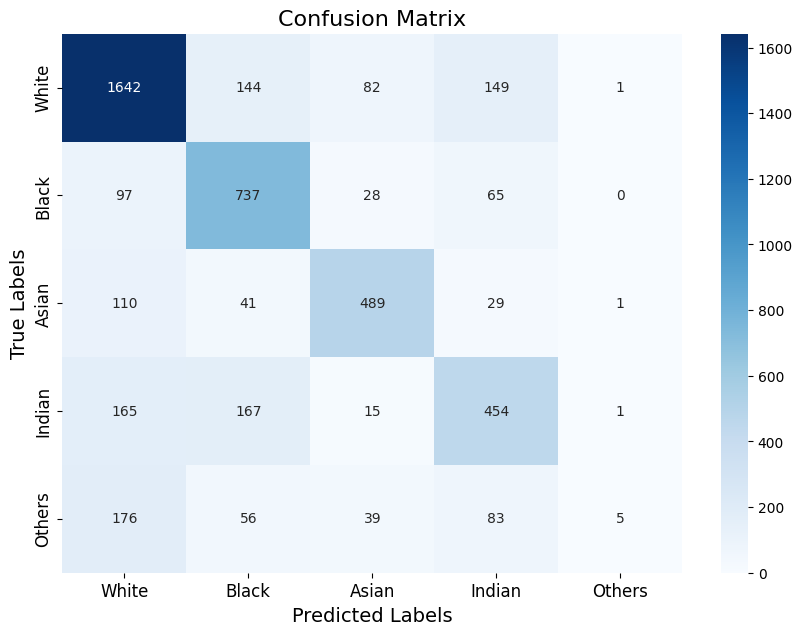


Classification Report:
              precision    recall  f1-score   support

       White       0.75      0.81      0.78      2018
       Black       0.64      0.80      0.71       927
       Asian       0.75      0.73      0.74       670
      Indian       0.58      0.57      0.57       802
      Others       0.62      0.01      0.03       359

    accuracy                           0.70      4776
   macro avg       0.67      0.58      0.57      4776
weighted avg       0.69      0.70      0.67      4776



In [10]:
all_labels = []
all_preds = []
eyes_net = AlexNet(ex,ey)
eyes_net.load_state_dict(torch.load("best_eyes_net.pth"))
eyes_net = eyes_net.to(device)


with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = eyes_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)


plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**NOSE TRAINING VALIDATION AND TEST**

In [11]:
# Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/nose/train", transform=transform_nose)
test_dataset = EthnicityDataset(root_dir="Dataset/nose/test", transform=transform_nose)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-fold Cross-Validation
k = 5  # Choose K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array to store results for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

num_epochs = 12
batch_size = 64

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model and optimizer for each fold
    nose_net = AlexNet(nx,ny)
    nose_net = nose_net.to(device)  # Ensure the model is on the correct GPU/CPU
    nose_optimizer = torch.optim.Adam(nose_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Metrics for each fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training for each fold
    for epoch in range(num_epochs):
        # Training Phase
        nose_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            nose_optimizer.zero_grad()

            # Forward pass
            outputs = nose_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            nose_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        nose_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = nose_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = nose_net.state_dict()
            print(f"New best model saved with Val Accuracy: {best_val_accuracy:.4f}")
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save results for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

torch.save(best_model_state, "best_nose_net.pth")

# Calculate the average metrics across all folds
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 229/229 [00:21<00:00, 10.53batch/s]


Fold 1, Epoch 1, Train Loss: 1.4468, Train Accuracy: 0.4669


Validating Fold 1, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 12.92batch/s]


New best model saved with Val Accuracy: 0.4845
Fold 1, Epoch 1, Val Loss: 1.3728, Val Accuracy: 0.4845


Training Fold 1, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.54batch/s]


Fold 1, Epoch 2, Train Loss: 1.3271, Train Accuracy: 0.4875


Validating Fold 1, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 13.59batch/s]


New best model saved with Val Accuracy: 0.4969
Fold 1, Epoch 2, Val Loss: 1.3676, Val Accuracy: 0.4969


Training Fold 1, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.63batch/s]


Fold 1, Epoch 3, Train Loss: 1.2812, Train Accuracy: 0.5034


Validating Fold 1, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 12.77batch/s]


New best model saved with Val Accuracy: 0.5114
Fold 1, Epoch 3, Val Loss: 1.2797, Val Accuracy: 0.5114


Training Fold 1, Epoch 4: 100%|██████████| 229/229 [00:21<00:00, 10.65batch/s]


Fold 1, Epoch 4, Train Loss: 1.2355, Train Accuracy: 0.5220


Validating Fold 1, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.71batch/s]


New best model saved with Val Accuracy: 0.5237
Fold 1, Epoch 4, Val Loss: 1.2236, Val Accuracy: 0.5237


Training Fold 1, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.71batch/s]


Fold 1, Epoch 5, Train Loss: 1.1939, Train Accuracy: 0.5396


Validating Fold 1, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 12.91batch/s]


Fold 1, Epoch 5, Val Loss: 1.2205, Val Accuracy: 0.4977


Training Fold 1, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.69batch/s]


Fold 1, Epoch 6, Train Loss: 1.1477, Train Accuracy: 0.5694


Validating Fold 1, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 12.77batch/s]


New best model saved with Val Accuracy: 0.5711
Fold 1, Epoch 6, Val Loss: 1.1332, Val Accuracy: 0.5711


Training Fold 1, Epoch 7: 100%|██████████| 229/229 [00:21<00:00, 10.60batch/s]


Fold 1, Epoch 7, Train Loss: 1.1126, Train Accuracy: 0.5883


Validating Fold 1, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 12.83batch/s]


New best model saved with Val Accuracy: 0.5774
Fold 1, Epoch 7, Val Loss: 1.1275, Val Accuracy: 0.5774


Training Fold 1, Epoch 8: 100%|██████████| 229/229 [00:21<00:00, 10.44batch/s]


Fold 1, Epoch 8, Train Loss: 1.0761, Train Accuracy: 0.6065


Validating Fold 1, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 13.30batch/s]


New best model saved with Val Accuracy: 0.6020
Fold 1, Epoch 8, Val Loss: 1.0877, Val Accuracy: 0.6020


Training Fold 1, Epoch 9: 100%|██████████| 229/229 [00:21<00:00, 10.57batch/s]


Fold 1, Epoch 9, Train Loss: 1.0318, Train Accuracy: 0.6259


Validating Fold 1, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.02batch/s]


New best model saved with Val Accuracy: 0.6256
Fold 1, Epoch 9, Val Loss: 1.0355, Val Accuracy: 0.6256


Training Fold 1, Epoch 10: 100%|██████████| 229/229 [00:21<00:00, 10.51batch/s]


Fold 1, Epoch 10, Train Loss: 0.9923, Train Accuracy: 0.6382


Validating Fold 1, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 12.96batch/s]


Fold 1, Epoch 10, Val Loss: 1.0833, Val Accuracy: 0.6111


Training Fold 1, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.54batch/s]


Fold 1, Epoch 11, Train Loss: 0.9728, Train Accuracy: 0.6528


Validating Fold 1, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 12.88batch/s]


Fold 1, Epoch 11, Val Loss: 1.1103, Val Accuracy: 0.6007


Training Fold 1, Epoch 12: 100%|██████████| 229/229 [00:22<00:00, 10.39batch/s]


Fold 1, Epoch 12, Train Loss: 0.9416, Train Accuracy: 0.6651


Validating Fold 1, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 13.23batch/s]


Fold 1, Epoch 12, Val Loss: 1.0222, Val Accuracy: 0.6253
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 229/229 [00:21<00:00, 10.71batch/s]


Fold 2, Epoch 1, Train Loss: 1.4000, Train Accuracy: 0.4668


Validating Fold 2, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 13.66batch/s]


Fold 2, Epoch 1, Val Loss: 1.3423, Val Accuracy: 0.5051


Training Fold 2, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.85batch/s]


Fold 2, Epoch 2, Train Loss: 1.3096, Train Accuracy: 0.4954


Validating Fold 2, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 13.24batch/s]


Fold 2, Epoch 2, Val Loss: 1.3326, Val Accuracy: 0.5133


Training Fold 2, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.90batch/s]


Fold 2, Epoch 3, Train Loss: 1.2639, Train Accuracy: 0.5077


Validating Fold 2, Epoch 3: 100%|██████████| 58/58 [00:04<00:00, 13.06batch/s]


Fold 2, Epoch 3, Val Loss: 1.2014, Val Accuracy: 0.5467


Training Fold 2, Epoch 4: 100%|██████████| 229/229 [00:20<00:00, 10.96batch/s]


Fold 2, Epoch 4, Train Loss: 1.2096, Train Accuracy: 0.5348


Validating Fold 2, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 13.62batch/s]


Fold 2, Epoch 4, Val Loss: 1.1882, Val Accuracy: 0.5549


Training Fold 2, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.77batch/s]


Fold 2, Epoch 5, Train Loss: 1.1738, Train Accuracy: 0.5565


Validating Fold 2, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 14.85batch/s]


Fold 2, Epoch 5, Val Loss: 1.1818, Val Accuracy: 0.5316


Training Fold 2, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.62batch/s]


Fold 2, Epoch 6, Train Loss: 1.1316, Train Accuracy: 0.5731


Validating Fold 2, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 15.53batch/s]


Fold 2, Epoch 6, Val Loss: 1.1261, Val Accuracy: 0.5716


Training Fold 2, Epoch 7: 100%|██████████| 229/229 [00:21<00:00, 10.49batch/s]


Fold 2, Epoch 7, Train Loss: 1.0807, Train Accuracy: 0.5966


Validating Fold 2, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 15.67batch/s]


Fold 2, Epoch 7, Val Loss: 1.0955, Val Accuracy: 0.5957


Training Fold 2, Epoch 8: 100%|██████████| 229/229 [00:21<00:00, 10.42batch/s]


Fold 2, Epoch 8, Train Loss: 1.0537, Train Accuracy: 0.6166


Validating Fold 2, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 15.88batch/s]


Fold 2, Epoch 8, Val Loss: 1.1504, Val Accuracy: 0.5557


Training Fold 2, Epoch 9: 100%|██████████| 229/229 [00:21<00:00, 10.43batch/s]


Fold 2, Epoch 9, Train Loss: 1.0182, Train Accuracy: 0.6252


Validating Fold 2, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 15.68batch/s]


Fold 2, Epoch 9, Val Loss: 1.0578, Val Accuracy: 0.6182


Training Fold 2, Epoch 10: 100%|██████████| 229/229 [00:21<00:00, 10.45batch/s]


Fold 2, Epoch 10, Train Loss: 0.9831, Train Accuracy: 0.6403


Validating Fold 2, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.58batch/s]


New best model saved with Val Accuracy: 0.6491
Fold 2, Epoch 10, Val Loss: 0.9885, Val Accuracy: 0.6491


Training Fold 2, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.44batch/s]


Fold 2, Epoch 11, Train Loss: 0.9493, Train Accuracy: 0.6613


Validating Fold 2, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.74batch/s]


Fold 2, Epoch 11, Val Loss: 0.9951, Val Accuracy: 0.6439


Training Fold 2, Epoch 12: 100%|██████████| 229/229 [00:21<00:00, 10.44batch/s]


Fold 2, Epoch 12, Train Loss: 0.9211, Train Accuracy: 0.6730


Validating Fold 2, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.38batch/s]


New best model saved with Val Accuracy: 0.6584
Fold 2, Epoch 12, Val Loss: 0.9604, Val Accuracy: 0.6584
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 229/229 [00:21<00:00, 10.70batch/s]


Fold 3, Epoch 1, Train Loss: 1.4195, Train Accuracy: 0.4685


Validating Fold 3, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.88batch/s]


Fold 3, Epoch 1, Val Loss: 1.3701, Val Accuracy: 0.4615


Training Fold 3, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.67batch/s]


Fold 3, Epoch 2, Train Loss: 1.3101, Train Accuracy: 0.4944


Validating Fold 3, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.84batch/s]


Fold 3, Epoch 2, Val Loss: 1.2855, Val Accuracy: 0.4884


Training Fold 3, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.43batch/s]


Fold 3, Epoch 3, Train Loss: 1.2576, Train Accuracy: 0.5159


Validating Fold 3, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.68batch/s]


Fold 3, Epoch 3, Val Loss: 1.2331, Val Accuracy: 0.5127


Training Fold 3, Epoch 4: 100%|██████████| 229/229 [00:21<00:00, 10.79batch/s]


Fold 3, Epoch 4, Train Loss: 1.2183, Train Accuracy: 0.5375


Validating Fold 3, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 14.73batch/s]


Fold 3, Epoch 4, Val Loss: 1.1777, Val Accuracy: 0.5349


Training Fold 3, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.86batch/s]


Fold 3, Epoch 5, Train Loss: 1.1753, Train Accuracy: 0.5586


Validating Fold 3, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 13.52batch/s]


Fold 3, Epoch 5, Val Loss: 1.1927, Val Accuracy: 0.5634


Training Fold 3, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.84batch/s]


Fold 3, Epoch 6, Train Loss: 1.1402, Train Accuracy: 0.5744


Validating Fold 3, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 13.09batch/s]


Fold 3, Epoch 6, Val Loss: 1.1364, Val Accuracy: 0.5604


Training Fold 3, Epoch 7: 100%|██████████| 229/229 [00:21<00:00, 10.83batch/s]


Fold 3, Epoch 7, Train Loss: 1.0942, Train Accuracy: 0.5974


Validating Fold 3, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 13.25batch/s]


Fold 3, Epoch 7, Val Loss: 1.0730, Val Accuracy: 0.6097


Training Fold 3, Epoch 8: 100%|██████████| 229/229 [00:21<00:00, 10.86batch/s]


Fold 3, Epoch 8, Train Loss: 1.0493, Train Accuracy: 0.6149


Validating Fold 3, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 13.26batch/s]


Fold 3, Epoch 8, Val Loss: 1.0768, Val Accuracy: 0.5998


Training Fold 3, Epoch 9: 100%|██████████| 229/229 [00:21<00:00, 10.72batch/s]


Fold 3, Epoch 9, Train Loss: 1.0117, Train Accuracy: 0.6289


Validating Fold 3, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 14.53batch/s]


Fold 3, Epoch 9, Val Loss: 1.0256, Val Accuracy: 0.6316


Training Fold 3, Epoch 10: 100%|██████████| 229/229 [00:21<00:00, 10.59batch/s]


Fold 3, Epoch 10, Train Loss: 0.9785, Train Accuracy: 0.6506


Validating Fold 3, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.85batch/s]


Fold 3, Epoch 10, Val Loss: 1.0217, Val Accuracy: 0.6338


Training Fold 3, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.51batch/s]


Fold 3, Epoch 11, Train Loss: 0.9420, Train Accuracy: 0.6640


Validating Fold 3, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.78batch/s]


Fold 3, Epoch 11, Val Loss: 1.0080, Val Accuracy: 0.6472


Training Fold 3, Epoch 12: 100%|██████████| 229/229 [00:21<00:00, 10.48batch/s]


Fold 3, Epoch 12, Train Loss: 0.9229, Train Accuracy: 0.6684


Validating Fold 3, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.28batch/s]


New best model saved with Val Accuracy: 0.6645
Fold 3, Epoch 12, Val Loss: 0.9602, Val Accuracy: 0.6645
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 229/229 [00:21<00:00, 10.61batch/s]


Fold 4, Epoch 1, Train Loss: 1.4404, Train Accuracy: 0.4595


Validating Fold 4, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.91batch/s]


Fold 4, Epoch 1, Val Loss: 1.3487, Val Accuracy: 0.4960


Training Fold 4, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.59batch/s]


Fold 4, Epoch 2, Train Loss: 1.3271, Train Accuracy: 0.4938


Validating Fold 4, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 16.00batch/s]


Fold 4, Epoch 2, Val Loss: 1.3593, Val Accuracy: 0.4834


Training Fold 4, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.61batch/s]


Fold 4, Epoch 3, Train Loss: 1.2865, Train Accuracy: 0.4997


Validating Fold 4, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.98batch/s]


Fold 4, Epoch 3, Val Loss: 1.2308, Val Accuracy: 0.5075


Training Fold 4, Epoch 4: 100%|██████████| 229/229 [00:21<00:00, 10.61batch/s]


Fold 4, Epoch 4, Train Loss: 1.2470, Train Accuracy: 0.5199


Validating Fold 4, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 15.65batch/s]


Fold 4, Epoch 4, Val Loss: 1.1823, Val Accuracy: 0.5508


Training Fold 4, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.74batch/s]


Fold 4, Epoch 5, Train Loss: 1.2075, Train Accuracy: 0.5344


Validating Fold 4, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 15.23batch/s]


Fold 4, Epoch 5, Val Loss: 1.1761, Val Accuracy: 0.5407


Training Fold 4, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.85batch/s]


Fold 4, Epoch 6, Train Loss: 1.1702, Train Accuracy: 0.5536


Validating Fold 4, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 13.27batch/s]


Fold 4, Epoch 6, Val Loss: 1.1043, Val Accuracy: 0.5993


Training Fold 4, Epoch 7: 100%|██████████| 229/229 [00:20<00:00, 10.93batch/s]


Fold 4, Epoch 7, Train Loss: 1.1287, Train Accuracy: 0.5766


Validating Fold 4, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 13.36batch/s]


Fold 4, Epoch 7, Val Loss: 1.0940, Val Accuracy: 0.5812


Training Fold 4, Epoch 8: 100%|██████████| 229/229 [00:20<00:00, 10.96batch/s]


Fold 4, Epoch 8, Train Loss: 1.0985, Train Accuracy: 0.5970


Validating Fold 4, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 13.13batch/s]


Fold 4, Epoch 8, Val Loss: 1.0585, Val Accuracy: 0.6313


Training Fold 4, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 10.93batch/s]


Fold 4, Epoch 9, Train Loss: 1.0473, Train Accuracy: 0.6179


Validating Fold 4, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 14.44batch/s]


Fold 4, Epoch 9, Val Loss: 1.0213, Val Accuracy: 0.6456


Training Fold 4, Epoch 10: 100%|██████████| 229/229 [00:21<00:00, 10.80batch/s]


Fold 4, Epoch 10, Train Loss: 1.0102, Train Accuracy: 0.6341


Validating Fold 4, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.80batch/s]


Fold 4, Epoch 10, Val Loss: 0.9643, Val Accuracy: 0.6420


Training Fold 4, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.71batch/s]


Fold 4, Epoch 11, Train Loss: 0.9839, Train Accuracy: 0.6460


Validating Fold 4, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.84batch/s]


Fold 4, Epoch 11, Val Loss: 1.0277, Val Accuracy: 0.6396


Training Fold 4, Epoch 12: 100%|██████████| 229/229 [00:21<00:00, 10.54batch/s]


Fold 4, Epoch 12, Train Loss: 0.9553, Train Accuracy: 0.6582


Validating Fold 4, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.48batch/s]


Fold 4, Epoch 12, Val Loss: 0.9764, Val Accuracy: 0.6459
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 229/229 [00:21<00:00, 10.60batch/s]


Fold 5, Epoch 1, Train Loss: 1.4289, Train Accuracy: 0.4682


Validating Fold 5, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.60batch/s]


Fold 5, Epoch 1, Val Loss: 1.3173, Val Accuracy: 0.5031


Training Fold 5, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.52batch/s]


Fold 5, Epoch 2, Train Loss: 1.3104, Train Accuracy: 0.4990


Validating Fold 5, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.70batch/s]


Fold 5, Epoch 2, Val Loss: 1.2913, Val Accuracy: 0.5171


Training Fold 5, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.61batch/s]


Fold 5, Epoch 3, Train Loss: 1.2786, Train Accuracy: 0.5123


Validating Fold 5, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.48batch/s]


Fold 5, Epoch 3, Val Loss: 1.1980, Val Accuracy: 0.5374


Training Fold 5, Epoch 4: 100%|██████████| 229/229 [00:21<00:00, 10.63batch/s]


Fold 5, Epoch 4, Train Loss: 1.2456, Train Accuracy: 0.5200


Validating Fold 5, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 15.42batch/s]


Fold 5, Epoch 4, Val Loss: 1.2825, Val Accuracy: 0.5116


Training Fold 5, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.75batch/s]


Fold 5, Epoch 5, Train Loss: 1.2061, Train Accuracy: 0.5422


Validating Fold 5, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 14.00batch/s]


Fold 5, Epoch 5, Val Loss: 1.2094, Val Accuracy: 0.5511


Training Fold 5, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.54batch/s]


Fold 5, Epoch 6, Train Loss: 1.1719, Train Accuracy: 0.5566


Validating Fold 5, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 13.74batch/s]


Fold 5, Epoch 6, Val Loss: 1.2208, Val Accuracy: 0.5368


Training Fold 5, Epoch 7: 100%|██████████| 229/229 [00:21<00:00, 10.88batch/s]


Fold 5, Epoch 7, Train Loss: 1.1399, Train Accuracy: 0.5752


Validating Fold 5, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 13.12batch/s]


Fold 5, Epoch 7, Val Loss: 1.1234, Val Accuracy: 0.5998


Training Fold 5, Epoch 8: 100%|██████████| 229/229 [00:21<00:00, 10.86batch/s]


Fold 5, Epoch 8, Train Loss: 1.0919, Train Accuracy: 0.5952


Validating Fold 5, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 13.11batch/s]


Fold 5, Epoch 8, Val Loss: 1.0463, Val Accuracy: 0.6171


Training Fold 5, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 10.95batch/s]


Fold 5, Epoch 9, Train Loss: 1.0631, Train Accuracy: 0.6101


Validating Fold 5, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.91batch/s]


Fold 5, Epoch 9, Val Loss: 1.0672, Val Accuracy: 0.6220


Training Fold 5, Epoch 10: 100%|██████████| 229/229 [00:21<00:00, 10.79batch/s]


Fold 5, Epoch 10, Train Loss: 1.0140, Train Accuracy: 0.6337


Validating Fold 5, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.37batch/s]


Fold 5, Epoch 10, Val Loss: 0.9815, Val Accuracy: 0.6494


Training Fold 5, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.73batch/s]


Fold 5, Epoch 11, Train Loss: 0.9934, Train Accuracy: 0.6458


Validating Fold 5, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.44batch/s]


Fold 5, Epoch 11, Val Loss: 0.9910, Val Accuracy: 0.6291


Training Fold 5, Epoch 12: 100%|██████████| 229/229 [00:21<00:00, 10.64batch/s]


Fold 5, Epoch 12, Train Loss: 0.9586, Train Accuracy: 0.6598


Validating Fold 5, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.84batch/s]


Fold 5, Epoch 12, Val Loss: 0.9675, Val Accuracy: 0.6612
Average Training Loss: 1.1430
Average Validation Loss: 1.1414
Average Training Accuracy: 0.5733
Average Validation Accuracy: 0.5746


<ipython-input-12-dbd1234bceca>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nose_net.load_state_dict(torch.load("best_nose_net.pth"))


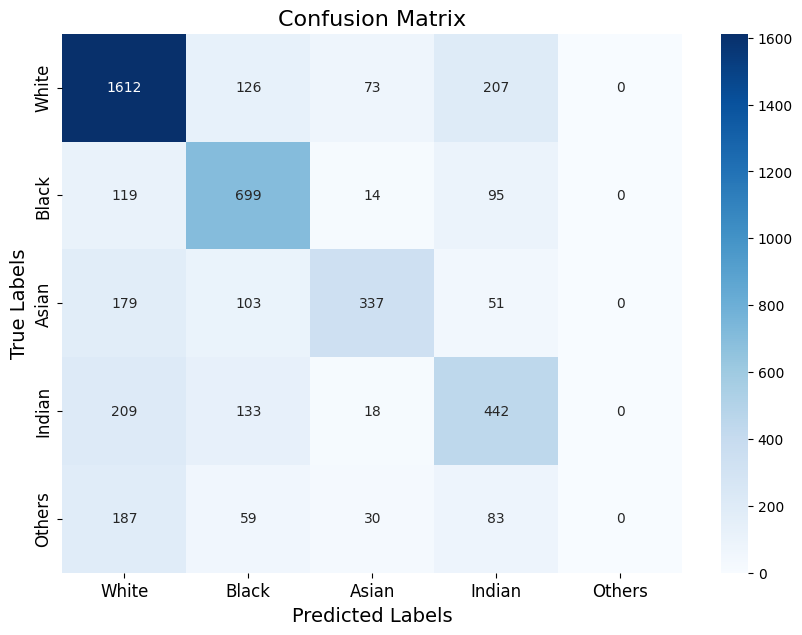


Classification Report:
              precision    recall  f1-score   support

       White       0.70      0.80      0.75      2018
       Black       0.62      0.75      0.68       927
       Asian       0.71      0.50      0.59       670
      Indian       0.50      0.55      0.53       802
      Others       0.00      0.00      0.00       359

    accuracy                           0.65      4776
   macro avg       0.51      0.52      0.51      4776
weighted avg       0.60      0.65      0.62      4776



In [12]:
all_labels = []
all_preds = []
nose_net = AlexNet(nx,ny)
nose_net.load_state_dict(torch.load("best_nose_net.pth"))
nose_net = nose_net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = nose_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

**MOUTH TRAINING VALIDATION AND TEST**

In [6]:
# Initialize the dataset
full_train_dataset = EthnicityDataset(root_dir="Dataset/mouth/train", transform=transform_mouth)
test_dataset = EthnicityDataset(root_dir="Dataset/mouth/test", transform=transform_mouth)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# K-fold Cross-Validation
k = 5  # Choose K = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Array to store results for each fold
fold_train_losses = []
fold_val_losses = []
fold_train_accuracies = []
fold_val_accuracies = []
best_val_accuracy = 0.0
best_model_state = None

num_epochs = 12
batch_size = 64

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_train_dataset)))):
    print(f"Fold {fold + 1}/{k}")

    # Create subsets for training and validation
    train_subset = Subset(full_train_dataset, train_idx)
    val_subset = Subset(full_train_dataset, val_idx)

    # Create data loaders for the current fold
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Reinitialize the model and optimizer for each fold
    mouth_net = AlexNet(mx,my)
    mouth_net = mouth_net.to(device)  # Ensure the model is on the correct GPU/CPU
    mouth_optimizer = torch.optim.Adam(mouth_net.parameters(), lr=0.001, weight_decay=0.0001)

    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Metrics for each fold
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training for each fold
    for epoch in range(num_epochs):
        # Training Phase
        mouth_net.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for data in tqdm(train_loader, desc=f"Training Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the gradients
            mouth_optimizer.zero_grad()

            # Forward pass
            outputs = mouth_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            mouth_optimizer.step()

            running_loss += loss.item()

            # Accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation Phase
        mouth_net.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Validating Fold {fold + 1}, Epoch {epoch + 1}", unit="batch"):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = mouth_net(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()

                # Accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_running_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = mouth_net.state_dict()
            print(f"New best model saved with Val Accuracy: {best_val_accuracy:.4f}")
        print(f"Fold {fold + 1}, Epoch {epoch + 1}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Save results for the current fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_accuracies.append(train_accuracies)
    fold_val_accuracies.append(val_accuracies)

torch.save(best_model_state, "best_mouth_net.pth")

# Calculate the average metrics across all folds
mean_train_loss = np.mean([np.mean(fold) for fold in fold_train_losses])
mean_val_loss = np.mean([np.mean(fold) for fold in fold_val_losses])
mean_train_accuracy = np.mean([np.mean(fold) for fold in fold_train_accuracies])
mean_val_accuracy = np.mean([np.mean(fold) for fold in fold_val_accuracies])

print(f"Average Training Loss: {mean_train_loss:.4f}")
print(f"Average Validation Loss: {mean_val_loss:.4f}")
print(f"Average Training Accuracy: {mean_train_accuracy:.4f}")
print(f"Average Validation Accuracy: {mean_val_accuracy:.4f}")

Fold 1/5


Training Fold 1, Epoch 1: 100%|██████████| 229/229 [00:33<00:00,  6.90batch/s]


Fold 1, Epoch 1, Train Loss: 1.3560, Train Accuracy: 0.4993


Validating Fold 1, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.66batch/s]


New best model saved with Val Accuracy: 0.5464
Fold 1, Epoch 1, Val Loss: 1.1964, Val Accuracy: 0.5464


Training Fold 1, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.86batch/s]


Fold 1, Epoch 2, Train Loss: 1.2052, Train Accuracy: 0.5420


Validating Fold 1, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.31batch/s]


New best model saved with Val Accuracy: 0.5579
Fold 1, Epoch 2, Val Loss: 1.1863, Val Accuracy: 0.5579


Training Fold 1, Epoch 3: 100%|██████████| 229/229 [00:20<00:00, 11.14batch/s]


Fold 1, Epoch 3, Train Loss: 1.1735, Train Accuracy: 0.5601


Validating Fold 1, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 14.66batch/s]


New best model saved with Val Accuracy: 0.5796
Fold 1, Epoch 3, Val Loss: 1.1547, Val Accuracy: 0.5796


Training Fold 1, Epoch 4: 100%|██████████| 229/229 [00:20<00:00, 11.10batch/s]


Fold 1, Epoch 4, Train Loss: 1.1234, Train Accuracy: 0.5803


Validating Fold 1, Epoch 4: 100%|██████████| 58/58 [00:04<00:00, 12.82batch/s]


New best model saved with Val Accuracy: 0.5938
Fold 1, Epoch 4, Val Loss: 1.0957, Val Accuracy: 0.5938


Training Fold 1, Epoch 5: 100%|██████████| 229/229 [00:20<00:00, 11.15batch/s]


Fold 1, Epoch 5, Train Loss: 1.0998, Train Accuracy: 0.5913


Validating Fold 1, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 13.28batch/s]


Fold 1, Epoch 5, Val Loss: 1.0865, Val Accuracy: 0.5916


Training Fold 1, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.85batch/s]


Fold 1, Epoch 6, Train Loss: 1.0764, Train Accuracy: 0.6004


Validating Fold 1, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 13.28batch/s]


New best model saved with Val Accuracy: 0.5996
Fold 1, Epoch 6, Val Loss: 1.0595, Val Accuracy: 0.5996


Training Fold 1, Epoch 7: 100%|██████████| 229/229 [00:20<00:00, 11.25batch/s]


Fold 1, Epoch 7, Train Loss: 1.0448, Train Accuracy: 0.6144


Validating Fold 1, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 13.28batch/s]


New best model saved with Val Accuracy: 0.6097
Fold 1, Epoch 7, Val Loss: 1.0514, Val Accuracy: 0.6097


Training Fold 1, Epoch 8: 100%|██████████| 229/229 [00:20<00:00, 11.24batch/s]


Fold 1, Epoch 8, Train Loss: 1.0280, Train Accuracy: 0.6224


Validating Fold 1, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 14.14batch/s]


New best model saved with Val Accuracy: 0.6250
Fold 1, Epoch 8, Val Loss: 1.0168, Val Accuracy: 0.6250


Training Fold 1, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 11.04batch/s]


Fold 1, Epoch 9, Train Loss: 1.0022, Train Accuracy: 0.6328


Validating Fold 1, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 15.31batch/s]


Fold 1, Epoch 9, Val Loss: 1.0265, Val Accuracy: 0.6160


Training Fold 1, Epoch 10: 100%|██████████| 229/229 [00:20<00:00, 10.96batch/s]


Fold 1, Epoch 10, Train Loss: 0.9780, Train Accuracy: 0.6459


Validating Fold 1, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.76batch/s]


New best model saved with Val Accuracy: 0.6256
Fold 1, Epoch 10, Val Loss: 1.0179, Val Accuracy: 0.6256


Training Fold 1, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.77batch/s]


Fold 1, Epoch 11, Train Loss: 0.9663, Train Accuracy: 0.6474


Validating Fold 1, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.93batch/s]


New best model saved with Val Accuracy: 0.6308
Fold 1, Epoch 11, Val Loss: 1.0086, Val Accuracy: 0.6308


Training Fold 1, Epoch 12: 100%|██████████| 229/229 [00:21<00:00, 10.75batch/s]


Fold 1, Epoch 12, Train Loss: 0.9382, Train Accuracy: 0.6594


Validating Fold 1, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.50batch/s]


Fold 1, Epoch 12, Val Loss: 0.9916, Val Accuracy: 0.6294
Fold 2/5


Training Fold 2, Epoch 1: 100%|██████████| 229/229 [00:20<00:00, 10.94batch/s]


Fold 2, Epoch 1, Train Loss: 1.3481, Train Accuracy: 0.5028


Validating Fold 2, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 16.11batch/s]


Fold 2, Epoch 1, Val Loss: 1.2374, Val Accuracy: 0.5278


Training Fold 2, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.88batch/s]


Fold 2, Epoch 2, Train Loss: 1.2079, Train Accuracy: 0.5438


Validating Fold 2, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.74batch/s]


Fold 2, Epoch 2, Val Loss: 1.2464, Val Accuracy: 0.5229


Training Fold 2, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.84batch/s]


Fold 2, Epoch 3, Train Loss: 1.1656, Train Accuracy: 0.5639


Validating Fold 2, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.98batch/s]


Fold 2, Epoch 3, Val Loss: 1.1028, Val Accuracy: 0.5785


Training Fold 2, Epoch 4: 100%|██████████| 229/229 [00:20<00:00, 10.91batch/s]


Fold 2, Epoch 4, Train Loss: 1.1126, Train Accuracy: 0.5867


Validating Fold 2, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 14.91batch/s]


Fold 2, Epoch 4, Val Loss: 1.1196, Val Accuracy: 0.5820


Training Fold 2, Epoch 5: 100%|██████████| 229/229 [00:20<00:00, 11.15batch/s]


Fold 2, Epoch 5, Train Loss: 1.0880, Train Accuracy: 0.6003


Validating Fold 2, Epoch 5: 100%|██████████| 58/58 [00:04<00:00, 14.08batch/s]


Fold 2, Epoch 5, Val Loss: 1.0814, Val Accuracy: 0.5900


Training Fold 2, Epoch 6: 100%|██████████| 229/229 [00:20<00:00, 11.25batch/s]


Fold 2, Epoch 6, Train Loss: 1.0574, Train Accuracy: 0.6094


Validating Fold 2, Epoch 6: 100%|██████████| 58/58 [00:04<00:00, 13.42batch/s]


Fold 2, Epoch 6, Val Loss: 1.0627, Val Accuracy: 0.6028


Training Fold 2, Epoch 7: 100%|██████████| 229/229 [00:20<00:00, 11.25batch/s]


Fold 2, Epoch 7, Train Loss: 1.0380, Train Accuracy: 0.6166


Validating Fold 2, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 13.33batch/s]


Fold 2, Epoch 7, Val Loss: 1.0808, Val Accuracy: 0.5787


Training Fold 2, Epoch 8: 100%|██████████| 229/229 [00:20<00:00, 11.29batch/s]


Fold 2, Epoch 8, Train Loss: 1.0237, Train Accuracy: 0.6270


Validating Fold 2, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 13.99batch/s]


Fold 2, Epoch 8, Val Loss: 1.0971, Val Accuracy: 0.5768


Training Fold 2, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 11.22batch/s]


Fold 2, Epoch 9, Train Loss: 0.9962, Train Accuracy: 0.6350


Validating Fold 2, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 15.37batch/s]


Fold 2, Epoch 9, Val Loss: 1.0156, Val Accuracy: 0.6248


Training Fold 2, Epoch 10: 100%|██████████| 229/229 [00:20<00:00, 10.93batch/s]


Fold 2, Epoch 10, Train Loss: 0.9754, Train Accuracy: 0.6457


Validating Fold 2, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.23batch/s]


New best model saved with Val Accuracy: 0.6412
Fold 2, Epoch 10, Val Loss: 1.0011, Val Accuracy: 0.6412


Training Fold 2, Epoch 11: 100%|██████████| 229/229 [00:21<00:00, 10.72batch/s]


Fold 2, Epoch 11, Train Loss: 0.9545, Train Accuracy: 0.6550


Validating Fold 2, Epoch 11: 100%|██████████| 58/58 [00:03<00:00, 15.32batch/s]


Fold 2, Epoch 11, Val Loss: 1.0271, Val Accuracy: 0.6100


Training Fold 2, Epoch 12: 100%|██████████| 229/229 [00:21<00:00, 10.85batch/s]


Fold 2, Epoch 12, Train Loss: 0.9332, Train Accuracy: 0.6651


Validating Fold 2, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 15.49batch/s]


Fold 2, Epoch 12, Val Loss: 1.0527, Val Accuracy: 0.6168
Fold 3/5


Training Fold 3, Epoch 1: 100%|██████████| 229/229 [00:21<00:00, 10.75batch/s]


Fold 3, Epoch 1, Train Loss: 1.3323, Train Accuracy: 0.5173


Validating Fold 3, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.67batch/s]


Fold 3, Epoch 1, Val Loss: 1.2277, Val Accuracy: 0.5289


Training Fold 3, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.79batch/s]


Fold 3, Epoch 2, Train Loss: 1.2062, Train Accuracy: 0.5409


Validating Fold 3, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.97batch/s]


Fold 3, Epoch 2, Val Loss: 1.1626, Val Accuracy: 0.5563


Training Fold 3, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.80batch/s]


Fold 3, Epoch 3, Train Loss: 1.1615, Train Accuracy: 0.5598


Validating Fold 3, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.67batch/s]


Fold 3, Epoch 3, Val Loss: 1.2075, Val Accuracy: 0.5442


Training Fold 3, Epoch 4: 100%|██████████| 229/229 [00:21<00:00, 10.79batch/s]


Fold 3, Epoch 4, Train Loss: 1.1194, Train Accuracy: 0.5790


Validating Fold 3, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 15.52batch/s]


Fold 3, Epoch 4, Val Loss: 1.0982, Val Accuracy: 0.5987


Training Fold 3, Epoch 5: 100%|██████████| 229/229 [00:20<00:00, 10.92batch/s]


Fold 3, Epoch 5, Train Loss: 1.0861, Train Accuracy: 0.5954


Validating Fold 3, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 15.44batch/s]


Fold 3, Epoch 5, Val Loss: 1.1182, Val Accuracy: 0.5979


Training Fold 3, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.88batch/s]


Fold 3, Epoch 6, Train Loss: 1.0581, Train Accuracy: 0.6061


Validating Fold 3, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 15.22batch/s]


Fold 3, Epoch 6, Val Loss: 1.0200, Val Accuracy: 0.6231


Training Fold 3, Epoch 7: 100%|██████████| 229/229 [00:20<00:00, 11.02batch/s]


Fold 3, Epoch 7, Train Loss: 1.0323, Train Accuracy: 0.6179


Validating Fold 3, Epoch 7: 100%|██████████| 58/58 [00:04<00:00, 14.47batch/s]


Fold 3, Epoch 7, Val Loss: 1.1092, Val Accuracy: 0.5935


Training Fold 3, Epoch 8: 100%|██████████| 229/229 [00:20<00:00, 11.05batch/s]


Fold 3, Epoch 8, Train Loss: 1.0042, Train Accuracy: 0.6296


Validating Fold 3, Epoch 8: 100%|██████████| 58/58 [00:04<00:00, 13.82batch/s]


Fold 3, Epoch 8, Val Loss: 1.0204, Val Accuracy: 0.6330


Training Fold 3, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 11.23batch/s]


Fold 3, Epoch 9, Train Loss: 0.9909, Train Accuracy: 0.6343


Validating Fold 3, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 13.38batch/s]


Fold 3, Epoch 9, Val Loss: 0.9969, Val Accuracy: 0.6322


Training Fold 3, Epoch 10: 100%|██████████| 229/229 [00:20<00:00, 11.10batch/s]


Fold 3, Epoch 10, Train Loss: 0.9660, Train Accuracy: 0.6451


Validating Fold 3, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 13.19batch/s]


Fold 3, Epoch 10, Val Loss: 1.0039, Val Accuracy: 0.6217


Training Fold 3, Epoch 11: 100%|██████████| 229/229 [00:20<00:00, 11.18batch/s]


Fold 3, Epoch 11, Train Loss: 0.9466, Train Accuracy: 0.6517


Validating Fold 3, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 13.60batch/s]


Fold 3, Epoch 11, Val Loss: 1.0382, Val Accuracy: 0.6316


Training Fold 3, Epoch 12: 100%|██████████| 229/229 [00:20<00:00, 11.03batch/s]


Fold 3, Epoch 12, Train Loss: 0.9238, Train Accuracy: 0.6659


Validating Fold 3, Epoch 12: 100%|██████████| 58/58 [00:03<00:00, 14.66batch/s]


Fold 3, Epoch 12, Val Loss: 1.0080, Val Accuracy: 0.6294
Fold 4/5


Training Fold 4, Epoch 1: 100%|██████████| 229/229 [00:20<00:00, 11.05batch/s]


Fold 4, Epoch 1, Train Loss: 1.3586, Train Accuracy: 0.5010


Validating Fold 4, Epoch 1: 100%|██████████| 58/58 [00:03<00:00, 15.11batch/s]


Fold 4, Epoch 1, Val Loss: 1.2769, Val Accuracy: 0.5157


Training Fold 4, Epoch 2: 100%|██████████| 229/229 [00:21<00:00, 10.85batch/s]


Fold 4, Epoch 2, Train Loss: 1.2156, Train Accuracy: 0.5409


Validating Fold 4, Epoch 2: 100%|██████████| 58/58 [00:03<00:00, 15.48batch/s]


Fold 4, Epoch 2, Val Loss: 1.2010, Val Accuracy: 0.5371


Training Fold 4, Epoch 3: 100%|██████████| 229/229 [00:21<00:00, 10.80batch/s]


Fold 4, Epoch 3, Train Loss: 1.1760, Train Accuracy: 0.5522


Validating Fold 4, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 16.22batch/s]


Fold 4, Epoch 3, Val Loss: 1.1328, Val Accuracy: 0.5568


Training Fold 4, Epoch 4: 100%|██████████| 229/229 [00:21<00:00, 10.88batch/s]


Fold 4, Epoch 4, Train Loss: 1.1272, Train Accuracy: 0.5718


Validating Fold 4, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 16.17batch/s]


Fold 4, Epoch 4, Val Loss: 1.1433, Val Accuracy: 0.5703


Training Fold 4, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.83batch/s]


Fold 4, Epoch 5, Train Loss: 1.1071, Train Accuracy: 0.5921


Validating Fold 4, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 15.32batch/s]


Fold 4, Epoch 5, Val Loss: 1.0905, Val Accuracy: 0.5804


Training Fold 4, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.85batch/s]


Fold 4, Epoch 6, Train Loss: 1.0733, Train Accuracy: 0.6011


Validating Fold 4, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 15.52batch/s]


Fold 4, Epoch 6, Val Loss: 1.0700, Val Accuracy: 0.6083


Training Fold 4, Epoch 7: 100%|██████████| 229/229 [00:21<00:00, 10.77batch/s]


Fold 4, Epoch 7, Train Loss: 1.0428, Train Accuracy: 0.6148


Validating Fold 4, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 15.85batch/s]


Fold 4, Epoch 7, Val Loss: 1.1157, Val Accuracy: 0.5842


Training Fold 4, Epoch 8: 100%|██████████| 229/229 [00:20<00:00, 10.92batch/s]


Fold 4, Epoch 8, Train Loss: 1.0282, Train Accuracy: 0.6184


Validating Fold 4, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 15.99batch/s]


Fold 4, Epoch 8, Val Loss: 1.0270, Val Accuracy: 0.6231


Training Fold 4, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 10.98batch/s]


Fold 4, Epoch 9, Train Loss: 1.0033, Train Accuracy: 0.6301


Validating Fold 4, Epoch 9: 100%|██████████| 58/58 [00:04<00:00, 14.27batch/s]


Fold 4, Epoch 9, Val Loss: 1.0497, Val Accuracy: 0.6146


Training Fold 4, Epoch 10: 100%|██████████| 229/229 [00:20<00:00, 11.01batch/s]


Fold 4, Epoch 10, Train Loss: 0.9852, Train Accuracy: 0.6376


Validating Fold 4, Epoch 10: 100%|██████████| 58/58 [00:04<00:00, 13.66batch/s]


Fold 4, Epoch 10, Val Loss: 1.0099, Val Accuracy: 0.6352


Training Fold 4, Epoch 11: 100%|██████████| 229/229 [00:20<00:00, 11.23batch/s]


Fold 4, Epoch 11, Train Loss: 0.9624, Train Accuracy: 0.6504


Validating Fold 4, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 13.43batch/s]


Fold 4, Epoch 11, Val Loss: 1.0254, Val Accuracy: 0.6248


Training Fold 4, Epoch 12: 100%|██████████| 229/229 [00:20<00:00, 11.03batch/s]


Fold 4, Epoch 12, Train Loss: 0.9512, Train Accuracy: 0.6537


Validating Fold 4, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 13.19batch/s]


Fold 4, Epoch 12, Val Loss: 1.0197, Val Accuracy: 0.6270
Fold 5/5


Training Fold 5, Epoch 1: 100%|██████████| 229/229 [00:20<00:00, 11.23batch/s]


Fold 5, Epoch 1, Train Loss: 1.3442, Train Accuracy: 0.5027


Validating Fold 5, Epoch 1: 100%|██████████| 58/58 [00:04<00:00, 13.29batch/s]


Fold 5, Epoch 1, Val Loss: 1.2274, Val Accuracy: 0.5303


Training Fold 5, Epoch 2: 100%|██████████| 229/229 [00:20<00:00, 11.18batch/s]


Fold 5, Epoch 2, Train Loss: 1.2107, Train Accuracy: 0.5388


Validating Fold 5, Epoch 2: 100%|██████████| 58/58 [00:04<00:00, 14.46batch/s]


Fold 5, Epoch 2, Val Loss: 1.1754, Val Accuracy: 0.5486


Training Fold 5, Epoch 3: 100%|██████████| 229/229 [00:20<00:00, 11.10batch/s]


Fold 5, Epoch 3, Train Loss: 1.1655, Train Accuracy: 0.5618


Validating Fold 5, Epoch 3: 100%|██████████| 58/58 [00:03<00:00, 15.16batch/s]


Fold 5, Epoch 3, Val Loss: 1.1598, Val Accuracy: 0.5585


Training Fold 5, Epoch 4: 100%|██████████| 229/229 [00:20<00:00, 10.94batch/s]


Fold 5, Epoch 4, Train Loss: 1.1230, Train Accuracy: 0.5799


Validating Fold 5, Epoch 4: 100%|██████████| 58/58 [00:03<00:00, 15.59batch/s]


Fold 5, Epoch 4, Val Loss: 1.1478, Val Accuracy: 0.5609


Training Fold 5, Epoch 5: 100%|██████████| 229/229 [00:21<00:00, 10.86batch/s]


Fold 5, Epoch 5, Train Loss: 1.0859, Train Accuracy: 0.5983


Validating Fold 5, Epoch 5: 100%|██████████| 58/58 [00:03<00:00, 15.75batch/s]


Fold 5, Epoch 5, Val Loss: 1.1230, Val Accuracy: 0.5812


Training Fold 5, Epoch 6: 100%|██████████| 229/229 [00:21<00:00, 10.70batch/s]


Fold 5, Epoch 6, Train Loss: 1.0556, Train Accuracy: 0.6064


Validating Fold 5, Epoch 6: 100%|██████████| 58/58 [00:03<00:00, 15.98batch/s]


Fold 5, Epoch 6, Val Loss: 1.0935, Val Accuracy: 0.5987


Training Fold 5, Epoch 7: 100%|██████████| 229/229 [00:21<00:00, 10.78batch/s]


Fold 5, Epoch 7, Train Loss: 1.0384, Train Accuracy: 0.6167


Validating Fold 5, Epoch 7: 100%|██████████| 58/58 [00:03<00:00, 15.65batch/s]


Fold 5, Epoch 7, Val Loss: 1.0924, Val Accuracy: 0.5878


Training Fold 5, Epoch 8: 100%|██████████| 229/229 [00:21<00:00, 10.90batch/s]


Fold 5, Epoch 8, Train Loss: 1.0079, Train Accuracy: 0.6309


Validating Fold 5, Epoch 8: 100%|██████████| 58/58 [00:03<00:00, 15.93batch/s]


Fold 5, Epoch 8, Val Loss: 1.0307, Val Accuracy: 0.6053


Training Fold 5, Epoch 9: 100%|██████████| 229/229 [00:20<00:00, 10.91batch/s]


Fold 5, Epoch 9, Train Loss: 0.9950, Train Accuracy: 0.6365


Validating Fold 5, Epoch 9: 100%|██████████| 58/58 [00:03<00:00, 15.74batch/s]


Fold 5, Epoch 9, Val Loss: 1.0400, Val Accuracy: 0.6185


Training Fold 5, Epoch 10: 100%|██████████| 229/229 [00:20<00:00, 10.97batch/s]


Fold 5, Epoch 10, Train Loss: 0.9757, Train Accuracy: 0.6412


Validating Fold 5, Epoch 10: 100%|██████████| 58/58 [00:03<00:00, 15.45batch/s]


Fold 5, Epoch 10, Val Loss: 1.0322, Val Accuracy: 0.6039


Training Fold 5, Epoch 11: 100%|██████████| 229/229 [00:20<00:00, 11.13batch/s]


Fold 5, Epoch 11, Train Loss: 0.9514, Train Accuracy: 0.6517


Validating Fold 5, Epoch 11: 100%|██████████| 58/58 [00:04<00:00, 14.05batch/s]


Fold 5, Epoch 11, Val Loss: 1.0270, Val Accuracy: 0.6190


Training Fold 5, Epoch 12: 100%|██████████| 229/229 [00:20<00:00, 11.18batch/s]


Fold 5, Epoch 12, Train Loss: 0.9238, Train Accuracy: 0.6663


Validating Fold 5, Epoch 12: 100%|██████████| 58/58 [00:04<00:00, 13.27batch/s]


Fold 5, Epoch 12, Val Loss: 1.0123, Val Accuracy: 0.6313
Average Training Loss: 1.0771
Average Validation Loss: 1.0892
Average Training Accuracy: 0.6014
Average Validation Accuracy: 0.5928


<ipython-input-7-be8757afd338>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mouth_net.load_state_dict(torch.load("best_mouth_net.pth"))


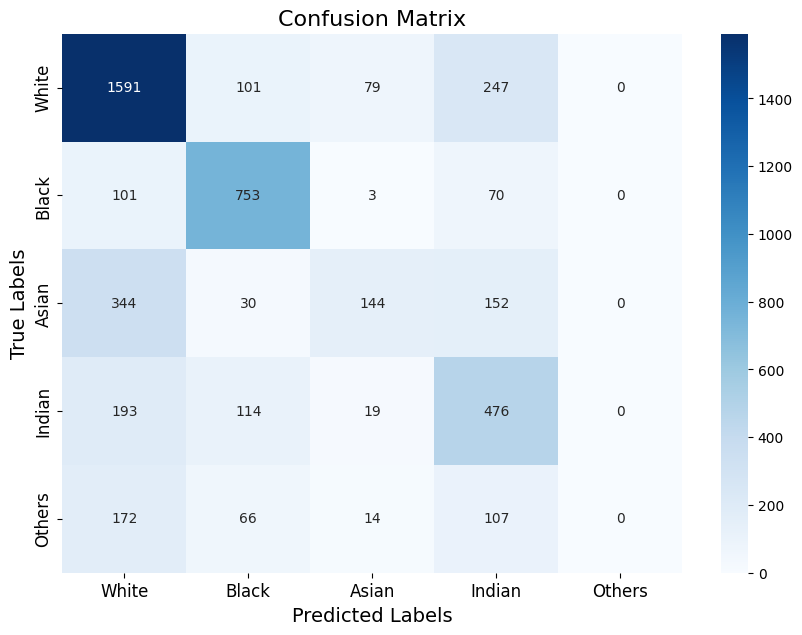


Classification Report:
              precision    recall  f1-score   support

       White       0.66      0.79      0.72      2018
       Black       0.71      0.81      0.76       927
       Asian       0.56      0.21      0.31       670
      Indian       0.45      0.59      0.51       802
      Others       0.00      0.00      0.00       359

    accuracy                           0.62      4776
   macro avg       0.48      0.48      0.46      4776
weighted avg       0.57      0.62      0.58      4776



In [7]:
all_labels = []
all_preds = []
mouth_net = AlexNet(mx,my)
mouth_net.load_state_dict(torch.load("best_mouth_net.pth"))
mouth_net = mouth_net.to(device)

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = mouth_net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))